## Introduction 

Notebook available on [https://github.com/openerror/SpatialCAHospitals](). Jump to the notebook's end for findings.

How are hospitals in California distributed, and are they serving every place equally? With open data from the state government, we can attempt answering these questions ourselves, with awesome graphics to boot.

This project draws on the following:
- [Shapefiles](https://data.ca.gov/dataset/ca-geographic-boundaries) delineating state and county boundaries
- [Data](https://www.oshpd.ca.gov/HID/Hospital-Utilization.html#Complete) on (non-federal) the utilization of non-federal hospitals
- [Population estimates](https://data.ca.gov/dataset/california-population-projection-county-age-gender-and-ethnicity of California), county-by-county

As of writing (July 2018), the most recent hospital data were generated in 2016. Therefore, population estimates from 2016 are used, instead of say census figures from 2010. In addition, as a first-pass analysis this project provides findings on a county-by-county basis. Finer geographical analysis is pending.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

### Reading all data files

In [2]:
# Pickled all CSVs in advance

# Fortunately, no cleaning needed for hospital data in the present analysis
# Can take addresses etc as provided
Hos16 = pd.read_pickle("data/Hos16.pickle")

countyShapes = gpd.read_file("data/boundaries/CA_Counties/CA_Counties_TIGER2016.shp")
stateShape = gpd.read_file("data/boundaries/CA_State/CA_State_TIGER2016.shp")
stateShape = stateShape.to_crs(epsg=4326)

Pop16 = pd.read_pickle("data/CAPopProj.pickle")

### Initial plot of all reporting hospitals!
Plotting all 500 hospitals that have reported data in 2016 onto "California". For reference, there are 4 non-reporting ones, negligible when spotting large scale spatial patterns. 

Perhaps not surprisingly, there are two overt clusters near Los Angeles and San Francisco.

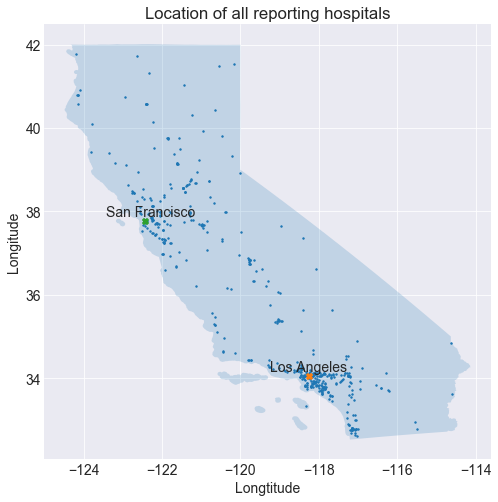

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.set_xlabel("Longtitude")
ax.set_ylabel("Longitude")
ax.set_title("Location of all reporting hospitals")

# Base layer: the outline of California
stateShape.plot(ax=ax, alpha=0.2)

# Plot location of all reporting hospitals
ax.scatter(Hos16["LONGITUDE"], Hos16["LATITUDE"], s=2)

# Finally, plot the big cities for reference of location
bigCities = {"Los Angeles": (-118.2437, 34.052),
             "San Francisco": (-122.4194, 37.7749)}
for city, longLat in bigCities.items():
    long, lat = longLat
    ax.text(long-1, lat+0.12, city)
    ax.scatter(long, lat, marker="X")

### Engineer and merge required features into 1 GeoPandas DF

The absolute population and the number of hospitals vary greatly across counties. For a fair comparison, this project will use fractional values instead --- fractional, relative to the state total. 

A county *may be* considered underserved, if the proportion of hospitals it contains is lower than the proportional population. This project hasn't come up with a strict, quantitative definition for "underserved", but the broad idea remains valid.

In [4]:
# Aggregate and obtain county populations; using 2016 projections to match 2016 hospital data
Pop16 = Pop16.loc[ Pop16.year==2016, : ]
totalPop16 = Pop16.pop_total.sum()

# Calcluate fractional population of each county, relative to the state's total
Pop16 = Pop16.groupby("county").pop_total.sum()
Pop16 = Pop16.reset_index()
Pop16["pop_frac"] = Pop16.loc[:, "pop_total"] / totalPop16
Pop16 = Pop16.drop(columns=["pop_total"])

# Change to title case for later merging
Pop16["county"] = Pop16["county"].str.title()

In [5]:
# Find number of hospitals in each county
numberOfHospitals = Hos16.groupby("COUNTY").count()
numberOfHospitals = numberOfHospitals["OSHPD_ID"].reset_index()
numberOfHospitals.rename(columns={"OSHPD_ID":"HosProp", "COUNTY":"county"}, 
                         inplace=True)

## Normalize against the total number of hospitals
numberOfHospitals["HosProp"] = numberOfHospitals["HosProp"] / Hos16.shape[0]

print("Number of counties represented in numberOfHospitals: {}".format(numberOfHospitals.shape[0]))
print("There are actually 58 counties though!")

Number of counties represented in numberOfHospitals: 55
There are actually 58 counties though!


To account for the missing counties (which contain no reporting hospitals), we must first identify them, and then add them to *numberOfHospitals*

In [6]:
# Obtain all the county names from shapefile
countyShapes.rename(columns={"NAME": "county"}, inplace=True)
countyNames = set(countyShapes.county)

# Find 'missing' counties by set difference
countyWithNoHos = list( countyNames.difference(numberOfHospitals.county) )
missing = pd.DataFrame({"county": countyWithNoHos, "HosProp": [0 for i in range(len(countyWithNoHos))]})
numberOfHospitals = pd.concat([numberOfHospitals, missing], axis=0)

In [7]:
print("Now there are {} hosptials represented in numberOfHospitals!".format(numberOfHospitals.shape[0]))

Now there are 58 hosptials represented in numberOfHospitals!


### Study and visualize the results!

Now merge all data frames with the geopandas dataframe (*countyShapes*), and plot!

In [8]:
finalDF = pd.merge(countyShapes, numberOfHospitals, how='inner', on=['county'])
finalDF = pd.merge(finalDF, Pop16, how='inner', on=['county'])
finalDF = gpd.GeoDataFrame(finalDF)

# Have to choose a projection!
finalDF.crs = {'init' :'epsg:3395'}    # Must first respect the original CRS implied in coordinate values
finalDF.to_crs(epsg=4326, inplace=True)  # Then, cast to Platte Carre; x-y are long and lat

Before making fancy geoplots, here're some insights into the data.

1. **Los Angeles** county has overwhelmingly more people AND hospitals, compared to any other single county.

2. In terms of both population and the number of hospitals, almost all of the *top* 10 counties come from the same set. The exceptions are Contra Cosca and **San Francisco**. SF is especially well-served, because it is 8th place in the number of hospitals, but not even within top 10 in population!

3. For both categories, the top 5 are from **southern California**, and the following 5 are all from **northern California**. No counties from in between.

4. The *bottom* 10, however, tell a slightly different story. 'Amador', 'Glenn', 'San Benito', 'Tehama' are among the counties with the least hospitals, but population wise they are **not** in the bottom 10! Could they be underserved in terms of medical resources??

In [9]:
# Top 10 in both categories
print(finalDF.loc[:, ["HosProp", "county"]].sort_values(by="HosProp", ascending=False).head(10))
print()
print(finalDF.loc[:, ["pop_frac", "county"]].sort_values(by="pop_frac", ascending=False).head(10))

    HosProp          county
5     0.230     Los Angeles
47    0.078          Orange
8     0.060       San Diego
23    0.056  San Bernardino
41    0.046         Alameda
31    0.044       Riverside
38    0.032     Santa Clara
10    0.032   San Francisco
36    0.030          Fresno
1     0.030      Sacramento

    pop_frac          county
5   0.259926     Los Angeles
8   0.083876       San Diego
47  0.080839          Orange
31  0.059986       Riverside
23  0.054579  San Bernardino
38  0.049047     Santa Clara
41  0.041614         Alameda
1   0.038285      Sacramento
24  0.028711    Contra Costa
36  0.025135          Fresno


In [10]:
bottom10_Hos = set( finalDF.loc[:, ["HosProp", "county"]].sort_values(by="HosProp").head(10)["county"] )
bottom10_Pop = set( finalDF.loc[:, ["pop_frac", "county"]].sort_values(by="pop_frac").head(10)["county"] )

print("The following hospitals are bottom 10 in terms of number of hospitals, but not in terms of population!")
bottom10_Hos.difference(bottom10_Pop)

The following hospitals are bottom 10 in terms of number of hospitals, but not in terms of population!


{'Amador', 'Glenn', 'San Benito', 'Tehama'}

Now let's make some geoplots to visualze, in color, both the distribution of population and hospitals! The top 10 results, in both categories, may not come as a surprise; they both cluster around metropolitan areas, namely LA and SF.

Let's study instead the bottom 10. Where are they located, and which are the "underserved" ones mentioned above?

In [11]:
# Coordinates come from Wikipedia pages for the counties
# Rough but sufficient for present use
underServedCounties = {"Glenn": (-122.39, 39.59),
                       "Amador": (-120.66, 38.44),
                       "San Benito": (-121.08, 36.61),
                       "Tehama": (-122.23, 40.13)
                      }

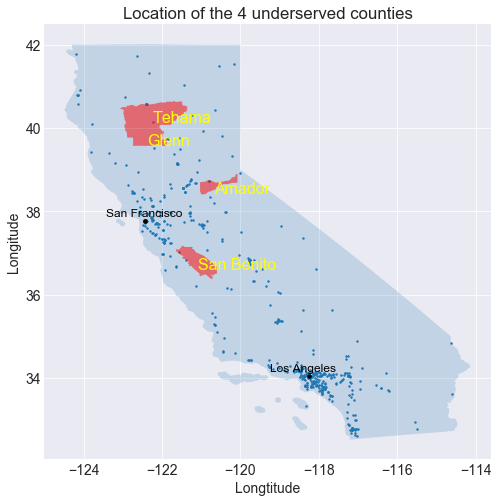

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Longtitude")
ax.set_ylabel("Longitude")
ax.set_title("Location of the 4 underserved counties")

# Base layer: the outline of California
stateShape.plot(ax=ax, alpha=0.2)

# Plot location of all reporting hospitals
ax.scatter(Hos16["LONGITUDE"], Hos16["LATITUDE"], s=2)

# Plot the SHAPE of the 4 counties
underServedCountyShapes = finalDF.loc[ finalDF.county.isin(underServedCounties.keys()) , "geometry"]
underServedCountyShapes.plot(ax=ax, color="red", alpha="0.5")

# Text labels for the 4 identified underserved counties
for place, longLat in underServedCounties.items():
    long, lat = longLat
    ax.text(long, lat, place, color="yellow", size=16)
    #ax.scatter(long, lat, marker="X", s=1, color="red")


# Finally, plot the big cities for reference of location
bigCities = {"Los Angeles": (-118.2437, 34.052),
             "San Francisco": (-122.4194, 37.7749)}
for city, longLat in bigCities.items():
    long, lat = longLat
    ax.text(long-1, lat+0.12, city, color="black", size=12)
    ax.scatter(long, lat, s=12, color='black')

## Conclusion

To summarize, here are the findings. Keeping in mind that there are 58 counties in total.

1. **Los Angeles** county has overwhelmingly more people AND hospitals, compared to any other single county. 20+% versus less than 10%.

2. **San Francisco** is also rather well-served. It is the 8th place in the number of hospitals, but doesn't even enter into top 10 population-wise.

3. **Top 10 counties** --- in both population and hospital numbers --- come from either northern or southern California; they also tend to neighbor LA/SF. "Middle" counties are not represented at all. 

4. **Underserved counties**: (Amador, Glenn, San Benito, Tehama). Population wise, they have more than the bottom 10. However, they ARE within the bottom 10, in terms of the number of hospitals they contain.

### Further directions for exploration
1. Study the availability of specialty care --- e.g. psychiatry
2. Compare the hospital/population ratio with other states or developed nations